In [3]:
import os
import tensorflow
import tensorflow.keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, Conv2DTranspose, Flatten, Dropout, ReLU, Input, MaxPooling1D, Reshape
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.backend as K

import numpy as np

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorf

LOAD DATABASES, CONCATENATE AND MIX THEM

In [4]:
rv = [54.]
nr = len(rv)



def load_and_shuffle_dbs(rv):
    paths = []
    for r in rv:
        paths.append(f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy")
    
    n_traj = 50000
    db = np.ndarray(shape=(nr*n_traj,2000,1))
    labels = []
    for path,r,i in zip(paths,rv,range(nr)):
        db1 = np.load(path)
        for j in range(n_traj):
            db[i*n_traj + j,:,0] = db1[j,0,:]
            labels.append(r)
    
    labels = np.array(labels)
    
    def unison_shuffled_copies(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]
    
    db, labels = unison_shuffled_copies(db, labels)
    return db, labels




db, labels = load_and_shuffle_dbs(rv)

PREPROCESSING

In [5]:
validation_split = 0.0

sig_len = len(db[0,:,0])
print(f"siglen: {sig_len}")
channels = 1 #len(db[0,0,:])
print(f"channels: {channels}")
n_traj = len(db[:,0,0])
print((f"n_traj: {n_traj}"))
# numero della prima traiettoria usata come validation
first_validation = n_traj #   round((1. - validation_split)*n_traj)
#  print(f"first_validation: {first_validation}")
db_train = np.ndarray(shape=(first_validation,sig_len,channels))
#db_test = np.ndarray(shape=(n_traj-first_validation,sig_len,channels))
db_train = db[:first_validation,:,0:channels]
#db_test = db[first_validation:,:,0:channels]
del db

print(db_train.shape)
#M = np.max(np.append(db_train, db_test))
#m = np.min(np.append(db_train, db_test))
M = np.max(db_train)
m = np.min(db_train)
print(M,m)
db_train = (db_train - m)/(M - m)
#db_test = (db_test - m)/(M - m)
M = np.max(db_train)
m = np.min(db_train)
print(M,m)

siglen: 2000
channels: 1
n_traj: 50000
(50000, 2000, 1)
31.27666666957781 -31.28223237314301
1.0 0.0


VISUALIZE DATA

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
%matplotlib inline

def plot_trajs(noise):
    import matplotlib.pyplot as plt
    gen_trajs = gen.predict(noise)
    plt.figure(figsize=(18, 2))
    for i, traj in enumerate(gen_trajs):
        plt.subplot(1, 1, i+1)
        plt.plot(traj)
        #plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    
def plot_trajs_vs(noise, real_trajs):
    import matplotlib.pyplot as plt
    gen_trajs = gen.predict(noise)
    plt.figure(figsize=(18, 4))
    for i, traj in enumerate(gen_trajs):
        plt.subplot(2, 1, i+1)
        plt.plot(traj)
        #plt.axis('off')
    for i in range(len(gen_trajs)):
        plt.subplot(2, 1, len(gen_trajs)+i+1)
        n = round(np.random.uniform(0,len(real_trajs[:,0,0])))
        plt.plot(real_trajs[n,:,:])
        #plt.axis('off')
    plt.tight_layout()
    plt.show()
    

def plot_disc_predictions(disc, gen, batch_size, noise_dim, db):
    noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
    plt.plot(disc.predict(gen.predict(noise)), label='fake')
    plt.plot(disc.predict(db[np.random.randint(len(db[:,0,0]),size=batch_size)]), label='real')
    plt.legend()
    plt.show()

ARCHITETTURA RETE NEURALE

# Losses

In [7]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def metric_1(y_true, y_pred):
    return K.mean(y_true) - K.mean(y_pred)

##  -1 vera
##  +1 falsa

# Generator

In [12]:
noise_dim = 100
sig_len, channels = len(db_train[0,:,0]), len(db_train[0,0,:])
fs = (20,1) # dimensione filtro
fm = 4 # numero filtri
init_sigma = 0.2 # varianza distribuzione parametri iniziali dei kernel
mean_init = 0.03
alpha = 0.3

def create_gen():
    generator = Sequential()
    # Starting size
    generator.add(Dense(800, kernel_initializer=RandomNormal(mean_init, init_sigma), input_dim=noise_dim))
    generator.add(ReLU(negative_slope=alpha))
    #20x1
    generator.add(Reshape((25, 1, 32)))
    #5x4
    generator.add(Conv2DTranspose(32, fs, strides=(5,1), padding='same', kernel_initializer=RandomNormal(mean_init, init_sigma)))
    generator.add(ReLU(negative_slope=alpha))
    #50x4
    generator.add(Conv2DTranspose(16, fs, strides=(2,1), padding='same', kernel_initializer=RandomNormal(mean_init, init_sigma)))
    generator.add(ReLU(negative_slope=alpha))
    generator.add(Conv2DTranspose(8, fs, strides=(2,1), padding='same', kernel_initializer=RandomNormal(mean_init, init_sigma)))
    generator.add(ReLU(negative_slope=alpha))
    #50x4
    generator.add(Conv2DTranspose(4, fs, strides=(2,1), padding='same', kernel_initializer=RandomNormal(mean_init, init_sigma)))
    generator.add(ReLU(negative_slope=alpha))
    generator.add(Conv2DTranspose(2, fs, strides=(2,1), padding='same', kernel_initializer=RandomNormal(mean_init, init_sigma)))
    generator.add(ReLU(negative_slope=alpha))
    generator.add(Conv2D(1, fs, padding='same', kernel_initializer=RandomNormal(mean_init, init_sigma)))

    generator.add(Reshape((2000, 1)))
    return generator

gen = create_gen()
gen.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 800)               80800     
_________________________________________________________________
re_lu_23 (ReLU)              (None, 800)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 25, 1, 32)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 125, 1, 32)        20512     
_________________________________________________________________
re_lu_24 (ReLU)              (None, 125, 1, 32)        0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 250, 1, 16)        10256     
_________________________________________________________________
re_lu_25 (ReLU)              (None, 250, 1, 16)       

# Discriminatore

In [86]:
sig_len, channels = len(db_train[0,:,0]), len(db_train[0,0,:])
fs = 20 # dimensione filtro
fm = 4 # numero filtri
sigma_init = 0.2 # varianza distribuzione parametri iniziali dei kernel
mean_init = 0.0

def create_disc():
    discriminator = Sequential()
    #2000x1
    discriminator.add(Conv1D(fm, fs, strides=4, padding='same', kernel_initializer=RandomNormal(mean_init, sigma_init), input_shape=(sig_len, channels)))
    discriminator.add(ReLU())
    #250x4
    discriminator.add(Conv1D(fm, fs, strides=4, padding='same', kernel_initializer=RandomNormal(mean_init, sigma_init)))    
    discriminator.add(ReLU())
    #50x4
    discriminator.add(Conv1D(fm, fs, strides=5, padding='same', kernel_initializer=RandomNormal(mean_init, sigma_init))) 
    discriminator.add(ReLU())
    #25x4
    discriminator.add(Conv1D(fm, fs, strides=5, padding='same', kernel_initializer=RandomNormal(mean_init, sigma_init))) 
    discriminator.add(ReLU())
    #5x4
    discriminator.add(Flatten())
    #20x1
    #discriminator.add(Dense(4*fm, activation='relu'))
    #64x1
    discriminator.add(Dense(1))
    #1x1
    opt = RMSprop()
    discriminator.compile(loss=wasserstein_loss, optimizer=opt, metrics=['accuracy'])
    return discriminator

disc = create_disc()

disc.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_111 (Conv1D)          (None, 500, 4)            84        
_________________________________________________________________
re_lu_111 (ReLU)             (None, 500, 4)            0         
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 125, 4)            324       
_________________________________________________________________
re_lu_112 (ReLU)             (None, 125, 4)            0         
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 25, 4)             324       
_________________________________________________________________
re_lu_113 (ReLU)             (None, 25, 4)             0         
_________________________________________________________________
conv1d_114 (Conv1D)          (None, 5, 4)            

### Gan

In [87]:
# Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
disc.trainable = False

# Link the two models to create the GAN
gan_input = Input(shape=(noise_dim,))
fake_traj = gen(gan_input)
gan_output = disc(fake_traj)
gan = Model(gan_input, gan_output)
optimizer = RMSprop(lr=0.00005)
gan.compile(loss=wasserstein_loss, optimizer=optimizer)

disc.trainable = True

# Training

In [88]:
disc_losses = [0]
gen_losses = [0]

Epoch: 0 	 Discriminator Loss: -484.41 		 Generator Loss: 0


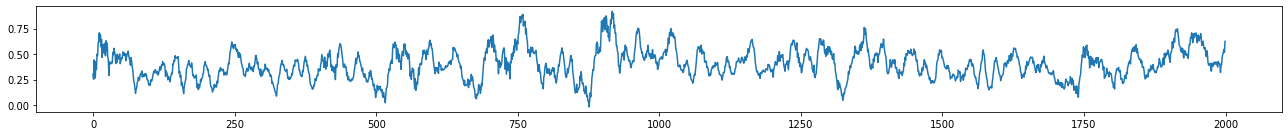

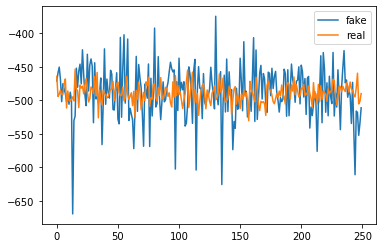

Epoch: 1 	 Discriminator Loss: -491.45 		 Generator Loss: 0
Epoch: 2 	 Discriminator Loss: -492.11 		 Generator Loss: 0
Epoch: 3 	 Discriminator Loss: -495.32 		 Generator Loss: 0
Epoch: 4 	 Discriminator Loss: -495.83 		 Generator Loss: 0
Epoch: 5 	 Discriminator Loss: -495.43 		 Generator Loss: 0


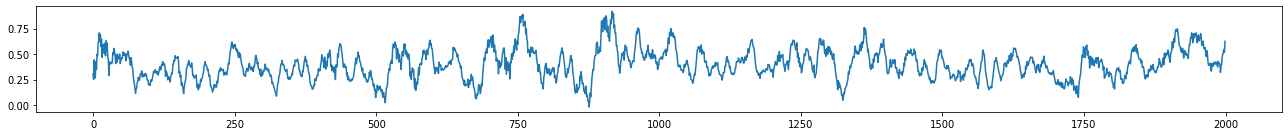

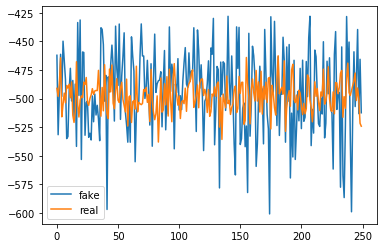

Epoch: 6 	 Discriminator Loss: -495.78 		 Generator Loss: 0
Epoch: 7 	 Discriminator Loss: -496.70 		 Generator Loss: 0
Epoch: 8 	 Discriminator Loss: -492.63 		 Generator Loss: 0
Epoch: 9 	 Discriminator Loss: -494.89 		 Generator Loss: 0
Epoch: 10 	 Discriminator Loss: -497.97 		 Generator Loss: 0


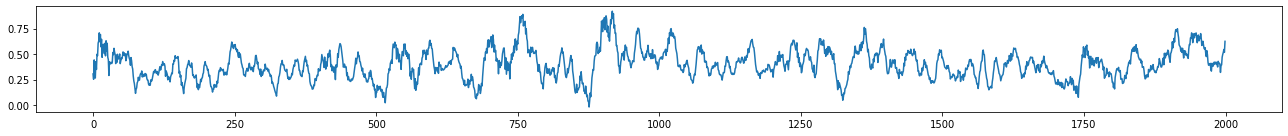

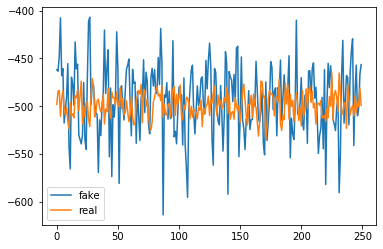

Epoch: 11 	 Discriminator Loss: -494.53 		 Generator Loss: 0
Epoch: 12 	 Discriminator Loss: -494.83 		 Generator Loss: 0
Epoch: 13 	 Discriminator Loss: -495.37 		 Generator Loss: 0
Epoch: 14 	 Discriminator Loss: -494.76 		 Generator Loss: 0
Epoch: 15 	 Discriminator Loss: -491.11 		 Generator Loss: 0


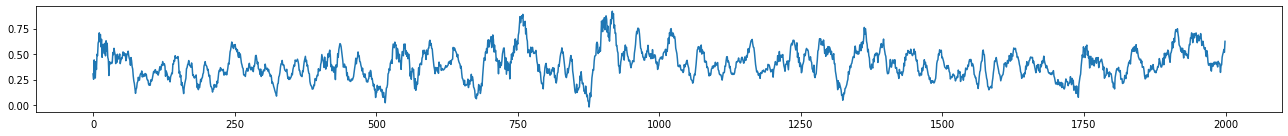

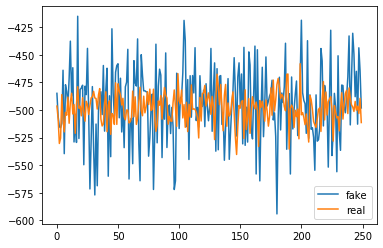

Epoch: 16 	 Discriminator Loss: -492.94 		 Generator Loss: 0
Epoch: 17 	 Discriminator Loss: -495.32 		 Generator Loss: 0
Epoch: 18 	 Discriminator Loss: -495.70 		 Generator Loss: 0
Epoch: 19 	 Discriminator Loss: -494.85 		 Generator Loss: 0
Epoch: 20 	 Discriminator Loss: -494.50 		 Generator Loss: 0


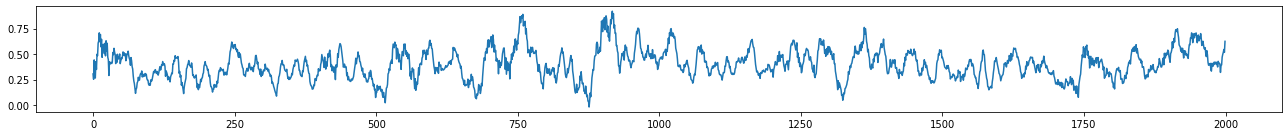

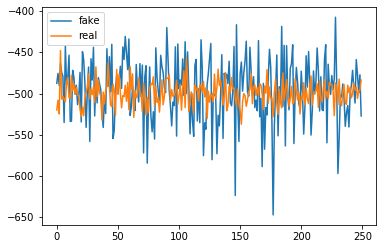

Epoch: 21 	 Discriminator Loss: -495.48 		 Generator Loss: 0


KeyboardInterrupt: 

In [89]:
def train_gan(epochs, batch_size, gen, disc, gan, train_ratio, disc_losses, gen_losses):
    clip_value = 0.1
    static_noise = np.random.normal(0, 1, size=(1, noise_dim))
    mini_batch_size = batch_size * train_ratio
    steps_per_epoch = len(db_train[:,0,0]) // batch_size
    valid = np.array([-1.]*batch_size)
    fake = np.array([1.]*batch_size)
    disc_labels = np.concatenate((valid, fake))
    for epoch in range(epochs):
        for ii in range(len(db_train[:,0,0]) // mini_batch_size):
            real_trajs = db_train[np.arange(ii*mini_batch_size, (ii+1)*mini_batch_size)]
            for jj in range(train_ratio):
                noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
                fake_trajs = gen.predict(noise)
                if ii == train_ratio:
                    kkk = disc.train_on_batch(fake_trajs, fake)
                    lll = disc.train_on_batch(mini_real_trajs, valid)
                    disc_losses.append([(kkk[0]+lll[0])/2., (kkk[1]+lll[1])/2.])
                else :
                    mini_real_trajs = real_trajs[jj*batch_size:(jj+1)*batch_size]
                    trajs = np.concatenate((mini_real_trajs, fake_trajs))
                    disc_losses.append(disc.train_on_batch(fake_trajs, fake))
                # Clip critic weights
                for l in disc.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                    l.set_weights(weights)
            
            #gen_labels = np.ones(batch_size)
            #gen_losses.append(gan.train_on_batch(noise, valid)) # training del generatore (per imbrogliare il discrim.)
            
            print(f'Epoch:{epoch}, batch:{ii*train_ratio+jj}/{steps_per_epoch}', end="\r")
        print(f'Epoch: {epoch} \t Discriminator Loss: {disc_losses[-1][0]:.2f} \t\t Generator Loss: {gen_losses[-1]}')
        if epoch%5==0:
            plot_trajs(static_noise)
            plot_disc_predictions(disc, gen, batch_size, noise_dim, db_train)

batch_size = 250
train_gan(epochs=300, batch_size=batch_size, gen=gen, disc=disc, gan=gan, train_ratio=1, disc_losses=disc_losses, gen_losses=gen_losses)

In [ ]:
import matplotlib.pyplot as plt

train_ratio = 5
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,6))
ax1.plot(gen_losses[-1000:], label='generator loss')
ax1.plot([l[0] for l in disc_losses[-1000:]], label='discriminator loss')
ax1.set_xlabel('batches')
ax2.set_xlabel('batches')
ax1.legend()
plt.show()

# Testing

In [58]:
noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
disc.evaluate(gen.predict(noise),np.array([-1.]*batch_size))
disc.evaluate(db_train[np.random.randint(len(db_train[:,0,0]),size=batch_size)],np.ones(batch_size))

250/250 [==============================] - 0s 86us/sample - loss: -0.0096 - acc: 0.0000e+00


[-0.009590114757418633, 0.0]

In [59]:
#disc.predict(gen.predict(noise))
#disc.predict(db_train[np.random.randint(50000*(1-validation_split),size=batch_size)])

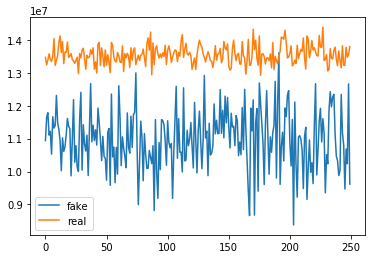

In [25]:
noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
plt.plot(disc.predict(gen.predict(noise)), label='fake')
plt.plot(disc.predict(db_train[np.random.randint(50000*(1-validation_split),size=batch_size)]), label='real')
plt.legend()
plt.show()

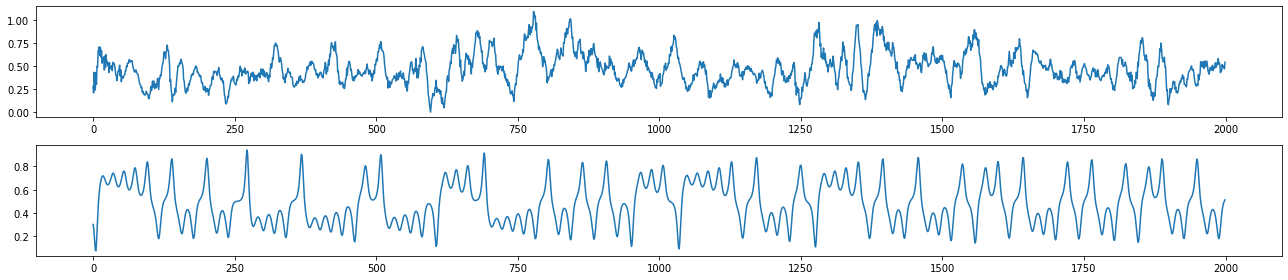

In [24]:
static_noise = np.random.normal(0, 1, size=(1, noise_dim))
#static_noise = np.random.uniform(0, 1, size=(1, noise_dim))
#static_noise = np.ndarray(shape=(1, noise_dim))
#static_noise[0,:] = 100
plot_trajs_vs(static_noise, db_train)

In [ ]:
noise = np.random.normal(0, 1, size=(10,100))

for traj in gen.predict(noise):
    plt.figure(figsize=(17,3))
    plt.plot(traj)
    plt.show()

# Saving

In [24]:
#disc.save('wgan_disc_big2.h5')
#gen.save('wgan_gen_big2.h5')
from tensorflow.keras.models import load_model
gen = load_model('models/wgan_gen_big2.h5')
#disc = load_model('models/wgan_disc_big2.h5')

W0510 16:43:49.667850 47081101045248 deprecation.py:506] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0510 16:43:50.324510 47081101045248 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [25]:
static_noise = np.random.normal(0, 1, size=(50000, noise_dim))
a = gen.predict(static_noise)

#np.save('../databases/gen_db_lorenz_54.0.npy', a)

In [30]:
a.shape

(50000, 2000, 1)